In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import jax
import jax.numpy as jnp
from jax import grad
from numpy.random import default_rng
from functools import partial
import time
import pandas as pd
# Fix a Random Number Generator for reproducibility
rng = default_rng(1337)


In [ ]:
# The following code implements a photonic circuit with trainable phases,

def rescale_data(data_set, min_val = -(np.pi)/2, max_val = (np.pi)/2):
    """
    Rescales the data set to the range [min_val, max_val].
    """
    min_data = np.copysign(np.ceil(np.abs(jnp.min(data_set))), jnp.min(data_set))
    max_data = np.copysign(np.ceil(np.abs(jnp.max(data_set))), jnp.max(data_set))
    
    # Rescale the data to the range [-pi/2, pi/2]
    rescaled_data = (data_set - min_data) / (max_data - min_data)
    # Now scale it to the desired range
    rescaled_data = rescaled_data * (max_val - min_val) + min_val
    return rescaled_data

# Initializing phases over the full interval [0,2pi] invites barren plateaus. It is much  
# better to initialize close to 0.

# This is the function used for loss calculation /predictions etc
# we need to inlcude only trainable phases here
# Considering alterante layers of data reuploading 

def initialize_phases(depth, width = None, mask = None):
    # Default case is Clements et al. layout, with all beam splitters tunable.
    if width == None:
        width = depth 
    if mask == None:
        #mask = np.ones(shape = [depth//2, width//2 -1, 2])
        mask = np.zeros((depth, width // 2, 2))
        for i in range(1, depth, 2):  # odd layers only
            mask[i] = 1.0

    # // 2 is integer division by 2, including rounding down.
    # The last two says that these two phases belong  to the same beamsplitter.
    # That is also why we divide the width by 2.
    phases = rng.uniform( low = -0.1, high = 0.1 , size =  [depth, width//2, 2])
    # The mask allows to set some phases to zero. This can be used if one wants to 
    # fix some beam splitters to the identity, for example for modularity.
    phases = mask*phases   
    phases = jnp.array(phases)
    return phases


# JAX likes to complain A LOT. Therefore, we need to explicitly declare variables as static.
# E.g. JAX doesn't like to use shapes of trainable arrays to define new arrays, or anything really.     
#@jax.jit
@partial(jax.jit, static_argnames=['layer'])
def layer_unitary(all_phases, layer, mask = None):
    """ 
    Returns a layer unitary implementing the optical layer of the trainable part with index 'layer'.
    """
    #layer = jax.lax.stop_gradient(layer) # doesn't work, don't ask me why.
    
    width = 2*jax.lax.stop_gradient(all_phases).shape[1] 
    # Stopping the gradient here allows to use the size of an input tensor to define other tensors.
    # Depth of the trainable part.
    depth = jax.lax.stop_gradient(all_phases).shape[0]
    if mask == None:
        # The default mask allows all phases to be trained
        mask = jnp.ones(shape = [depth, width//2])
    trainable_layer_phases = jnp.zeros(shape = [width//2 , 2])
    # Notice that the scalar operation '*' is applied for each beamsplitter of the layer individually, 
    # hidden in the fact that mask[layer] still has a dimension for the width, and the ':'.
    trainable_layer_phases = trainable_layer_phases.at[:, 0].set(mask[layer]*all_phases[layer,:,0])
    trainable_layer_phases = trainable_layer_phases.at[:, 1].set(mask[layer]*all_phases[layer,:,1])
    
    unitary = jnp.zeros(shape = [width, width], dtype = jnp.complex64)
    # Odd layers get an offset of one for placing beamsplitters.
    
    offset = (layer) % 2
    # Take care of wires that do not see a beamsplitter in this layer.
    if offset == 1:
        unitary = unitary.at[0,0].set(1.0)
        # If the width is even and the offset is one, also the last wire does not get a beamsplitter.
        if width % 2 == 0:
            # -1 gives the last entry
            unitary = unitary.at[-1, -1].set(1.0)
    else:  # Offset is 0, so for odd number of wires the last one cannot get a beamsplitter.  
        if width % 2 == 1:
            unitary = unitary.at[-1,-1].set(1.0)  
            
    # Now, write the actual layers
    # Since the entries look so different, I have no clever idea for how to vectorize/broadcast this...
    for index in range( (width-offset)//2):
        p = trainable_layer_phases[index,0]
        q = trainable_layer_phases[index,1]
        # Taken from old code. However, for p=q=0, it does not give the identity. Therefore the mask doesn't work.
        #unitary = unitary.at[offset+2*index, offset+2*index].set(jnp.exp(p*1j)*jnp.sin(q/2))
        #unitary = unitary.at[offset+2*index , offset+2*index+1].set(jnp.cos(q/2))
        #unitary =  unitary.at[offset+2*index+1, offset+2*index].set(jnp.exp(p*1j)*jnp.cos(q/2))
        #unitary = unitary.at[offset+2*index+1, offset+2*index+1].set(-jnp.sin(q/2))
        
        # To get the mask to work, I am using a different parameterization.
        unitary = unitary.at[offset+2*index, offset+2*index].set(0.5*(1+jnp.exp(1j*p)))
        unitary = unitary.at[offset+2*index , offset+2*index+1].set(0.5*(jnp.exp(1j*q)-jnp.exp(1j*(q+p))))
        unitary = unitary.at[offset+2*index+1, offset+2*index].set(0.5*(1-jnp.exp(1j*p)))
        unitary = unitary.at[offset+2*index+1, offset+2*index+1].set(0.5*(jnp.exp(1j*q)+jnp.exp(1j*(q+p))))
        

    # Taken from old code to remind myself.
    #splitters = jnp.array([[jnp.exp(p*1j)*np.sin(q/2), np.cos(q/2)], [np.exp(p*1j)*np.cos(q/2), -np.sin(q/2)]] for q,p in [q_all, p_all])

    return unitary


@jax.jit

def data_upload(data_set):
    """ Uploads the images into the photonics circuit """
    num_samples = jax.lax.stop_gradient(data_set).shape[0]
    # Each pixel gets its BS, therefore factor 2
    width = 2*jax.lax.stop_gradient(data_set).shape[1]
    # Again, the 3rd dimension with 2 represents the two phases for each beamsplitter. 
    phases = (jnp.pi/2)*jnp.ones(shape = [num_samples, width//2, 2]) 
    # The first of the phases of the beam splitters are set to be the feature values, the second phases are set 
    # to a constant pi/2 . 0 doesn't work because minimal and maximal pixel brightness act on the uniform superposition
    # state identically, with the parameterization below. For q = pi/2, minimal and maximal pixel brightness move the
    # uniform superposition into orthogonal states.  
    phases = phases.at[:,:,0].set(data_set)

    # Note that our "unitary" has 3 dimensions. The 1st dimension is a batching dimension, 
    # representing the index of the image. This allows to parallelize the calculation of hthe loss 
    # over the full training set later.
    unitary = jnp.zeros(shape = [num_samples, width, width], dtype = jnp.complex64)    
    for index in range( width//2 ):    
        #print('yes')
        p = phases[:, index, 0]
        q = phases[:, index, 1]
        # Note that p and q are 1-dimensional tensors here. We use that all operations here like jnp.exp are 
        # applied entry-by-entry to calculate the uploading unitary for all images in parallel.
        # That means each entry of p and q corresponds to one image, which corresponds to 
        # one entry in the : in dimension 0. 
        unitary = unitary.at[:,2*index, 2*index].set(0.5*(1+jnp.exp(1j*p)))
        unitary = unitary.at[:,2*index , 2*index+1].set(0.5*(jnp.exp(1j*q)-jnp.exp(1j*(q+p))))
        unitary = unitary.at[:,2*index+1, 2*index].set(0.5*(1-jnp.exp(1j*p)))
        unitary = unitary.at[:,2*index+1, 2*index+1].set(0.5*(jnp.exp(1j*q)+jnp.exp(1j*(q+p))))

    return unitary





#key = jax.random.PRNGKey(12)
def full_unitaries_data_reupload(phases, data_set):
    # Depth of the trainable part. 
    depth = jax.lax.stop_gradient(phases).shape[0]

    # Please note that we broadcast over images in the data set. 
    # The convention is that only the last two indices are used for matrix operations, 
    # the others are broadcasting dimensions used for batches of images.

    first_layers = data_upload(data_set)
    unitaries = first_layers
    
    for layer in range(1,depth): 
        
        if (layer)%2:
            unitaries = layer_unitary(phases, layer) @ unitaries
        # 'layer' is the layer index in the trainable part, starting from 0.
        else:        

            key = jax.random.PRNGKey(layer) 
            temp = jax.random.permutation(key, data_set.shape[1])
            temp = jax.lax.stop_gradient(temp)
            #temp = jnp.arange(data_set.shape[0])
            data_set_reupload = data_set[:,temp]
            
            #temp_permutation = data_set_reupload[:10, :3]
            #print(temp_permutation)

            unitaries_data_reupload = data_upload(data_set_reupload)
            unitaries = unitaries_data_reupload @ unitaries

    width = jax.lax.stop_gradient(unitaries).shape[-1]
    num_samples = jax.lax.stop_gradient(first_layers).shape[0]
    #print(width)
    
    uniform_state = jnp.ones(shape = [width], dtype = jnp.complex64)/jnp.sqrt(width)
    output_states = unitaries @ uniform_state

    # Since we have twice as many modes as pixels, we combine two neighboring output modes for each pixel.
    label_probs = jnp.zeros([num_samples , width])
    binary_probs = jnp.zeros([num_samples , 1])
    for j in range(width):
        label_probs = label_probs.at[:,j].set(jnp.abs(output_states[:,j]**2) )
    binary_probs_plus = jnp.sum(label_probs[:, :width // 2], axis=1, keepdims=True) #prob of being +1

   
    return unitaries, output_states, label_probs, binary_probs_plus



@jax.jit
def predict_reupload(phases, data_set):

    _, _, probs, binary_probs_plus = full_unitaries_data_reupload(phases, data_set)
    adjusted_binary_probs = jnp.where(binary_probs_plus > 0.5, binary_probs_plus,  - binary_probs_plus)
    
    return probs, adjusted_binary_probs


@jax.jit
def loss(phases, data_set, labels):
    num_samples = jax.lax.stop_gradient(data_set).shape[0]
    _, binary_predictions_plus = predict_reupload(phases , data_set)


    binary_predictions_plus = binary_predictions_plus.squeeze() # to match shapes
    binary_predictions_plus = jnp.abs(binary_predictions_plus) # as mentioned previously, we dont use the negative probs
    # Adjust predictions based on labels: if label == +1, keep it; else flip it
    adjusted_predictions = jnp.where(labels == 1, binary_predictions_plus, (1.0 - (binary_predictions_plus)))


    loss = ((1.0- adjusted_predictions)**2).mean()
  
    return loss


# JAX itself just calculates gradients, but doesn't come with an optimizer.
# So I took the Adam optimizer from the old code.
# Also, to prevent the kernel from crashing, I had to use jax.lax.scan here instead of for-loops.
# And that requires writing a function for the loop iteration, and put most of the variables into a 
# list called 'carry'... Thanks, JAX.
@jax.jit
def adam_step(carry, step):
    params, data_set, labels, m, v = carry
    shape_params = jax.lax.stop_gradient(params).shape
    
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    eta = step_size

    loss_val = jax.lax.stop_gradient(loss(params, data_set, labels))
    # I don't think the parameter shift rule of the old code works for photonic circuits.
    # However, JAX can calculate the gradients much faster anyway using backpropagation.
    grad = jax.grad(loss)(params, data_set, labels)

    m = beta1 * m + (1 - beta1) * jax.lax.stop_gradient(grad)
    v = beta2 * v + (1 - beta2) * jax.lax.stop_gradient(grad)**2
    m_hat = m / (1 - beta1**step)
    v_hat = v / (1 - beta2**step)
    params -= eta * m_hat / (jnp.sqrt(v_hat) + eps)
    step = step + 1
    
    carry = [params, data_set, labels, m, v]
    return carry, jnp.array([step, loss_val])


@jax.jit
def train(init):
    # Using for-loops ate all my RAM and then the kernel crashed.
    # But this awkward scan-loop seems to work very well!
    steps = jnp.arange(num_steps)+1
    carry, loss_mem = jax.lax.scan(adam_step, init, steps)
    # Note that jax.lax.scan automatically stacks the [step, loss_val] tensors we output
    # at the end of every Adam step. Therefore, the second output of scan is already
    # the full memory of all losses.
    return carry[0], loss_mem




In [23]:
# Load MNIST data for handwritten digits '3' and '5'
# The dataset has 'x' rows, each representing an image
# Each row has 'y' columns: The first y-1 columns each correspond to a pixel feature, and the last column is the label
# A label of +1 represents the digit '3', and -1 represents the digit '5'

file_path = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_3d_train.csv"
data_train = pd.read_csv(file_path)
data_train = jnp.array(data_train)


#final column in the data is for labels 
num_features = data_train.shape[1] -1 

file_path_1 = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_3d_test.csv"
data_test = pd.read_csv(file_path_1)
data_test = jnp.array(data_test)

num_steps = 1000


# Spliiting the data into training and testing sets

train_set = data_train[:,:num_features]

# Rescale the training set to the range [-pi/2, pi/2]
train_set = rescale_data(train_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

# The training labels are +1 for 3 and -1 for 5. 
train_labels = data_train[:,num_features]

# Not needed for now:
#train_labels_one_hot = jnp.zeros(shape = train_set.shape)
#train_labels_one_hot = train_labels_one_hot.at[tuple([jnp.arange(num_train),train_labels])].set(1)
test_set = data_test[:,:num_features]
# Rescale the test set to the range [-pi/2, pi/2]
test_set = rescale_data(test_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

test_labels = data_test[:,num_features]

In [24]:
# Not needed for now:

print( train_set.shape, train_labels.shape, test_set.shape, test_labels.shape)

# Initialize the phases

# Each feature gets its own mode. (previously, each feature had its own uploading BS so we had a factor of 2)
init_phases = initialize_phases(2*num_features, )  #quick check - multiply n * m to know total variable BS -- checks out for odd feature sizes and puts extra bs for even -- need fix 

#print(init_phases)

# If you didn't test any of the jitted functions yet, the ratio in times should be around a factor 10^3 - 10^5.
# The first time is larger because of the compilation.
# The second time is small because it just runs the compiled code.
# Also, try to get any of these run times in pure Python+Numpy.
b = time.time()
# The block_until_ready is supposed to only let Python continue when the compiled code has finished.
# For me, it's not reliable. Therefore, I print the results first before measuring the end time.
result1, result2, result3, x = jax.block_until_ready(full_unitaries_data_reupload)(init_phases, train_set)
print(result1.shape)
print(result2.shape)
print(result3.shape)
e = time.time()
print(e-b)
b = time.time()
result1 , result2, result3, x  = jax.block_until_ready(full_unitaries_data_reupload)(init_phases, train_set)
print(result1.shape)
print(result2.shape)
print(result3.shape)
e = time.time()
print(e-b)





(11551, 3) (11551,) (1901, 3) (1901,)
(11551, 6, 6)
(11551, 6)
(11551, 6)
0.332613468170166
(11551, 6, 6)
(11551, 6)
(11551, 6)
0.03084850311279297


Time 0.0 minutes
Loss on train set: 0.2585328
Loss on test set: 0.21355368


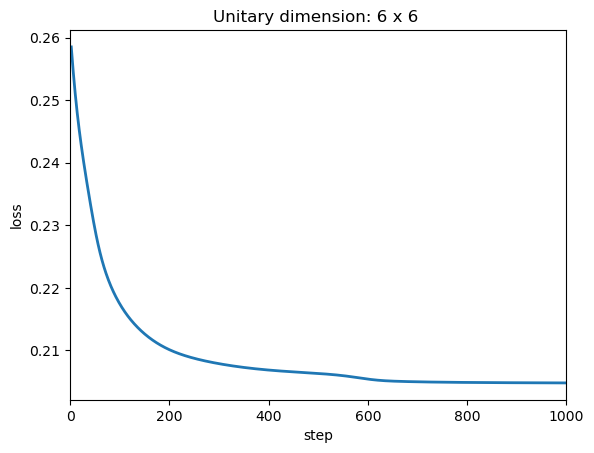

In [ ]:
#Training the circuit

init_phases = initialize_phases(10, 2*num_features)

step_size = 1e-2
# Initialize the carry for Adam.
init = [init_phases, train_set, train_labels, 0.0*init_phases, 0.0*init_phases] 
# Run the training.
b = time.time()
trained_phases, loss_mem = jax.block_until_ready(train)(init)
#print(loss_mem[0])
#print(loss_mem[10])
#print(loss_mem[100])
#print(loss_mem[1000])
e = time.time()
print('Time', (e-b)/60, 'minutes')


temp_loss = loss(init_phases, train_set, train_labels)
print('Loss on train set:', temp_loss)

temp_loss = loss(trained_phases, test_set, test_labels)
# Let's test on our test data:
print('Loss on test set:', temp_loss)

fig, ax = plt.subplots()
ax.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), linewidth=2, label=r"learning curve" )
ax.set(xlim = (0,1000), xlabel="step", ylabel = "loss",)
#ax.legend(fontsize=14)
unitary_shape = trained_phases.shape  
ax.set_title(f"Unitary dimension: {2*unitary_shape[1]} x {2*unitary_shape[1]} ")

plt.show()



In [44]:
# Checks 
print( jnp.allclose(result1[0]@jnp.conjugate(result1[0].T) , jnp.eye(2*num_features) , atol = 1e-05) )
probs, binary_probs = predict_reupload(init_phases, train_set)

#print(binary_probs)

#layer_unitary(init_phases, 3)

print(init_phases) 
print(trained_phases)

True
[[[ 0.         -0.        ]
  [ 0.         -0.        ]
  [ 0.         -0.        ]]

 [[ 0.03265399 -0.02353464]
  [-0.00495538  0.06148639]
  [ 0.09709329  0.0083733 ]]

 [[ 0.         -0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.05925841  0.0592571 ]
  [ 0.0634691  -0.05198175]
  [-0.04668498  0.03736189]]

 [[-0.          0.        ]
  [ 0.          0.        ]
  [-0.         -0.        ]]

 [[-0.02038927  0.03647986]
  [ 0.00734904 -0.07128119]
  [-0.06878687 -0.04701556]]

 [[-0.          0.        ]
  [ 0.          0.        ]
  [-0.         -0.        ]]

 [[ 0.05672368 -0.07817798]
  [ 0.01176185  0.0921592 ]
  [-0.02660865 -0.0935223 ]]

 [[ 0.         -0.        ]
  [ 0.         -0.        ]
  [ 0.          0.        ]]

 [[ 0.03199976  0.00409065]
  [ 0.06214538 -0.09295043]
  [ 0.08865102 -0.03275838]]]
[[[ 0.         -0.        ]
  [ 0.         -0.        ]
  [ 0.         -0.        ]]

 [[-0.6904014  -2.5804846 ]
  [-1.8551099  -0.508

Step size: 10
Time: 0.00 seconds (0.00 minutes)
Step size: 1
Time: 0.00 seconds (0.00 minutes)
Step size: 0.1
Time: 0.00 seconds (0.00 minutes)
Step size: 0.01
Time: 0.00 seconds (0.00 minutes)
Step size: 0.001
Time: 0.00 seconds (0.00 minutes)


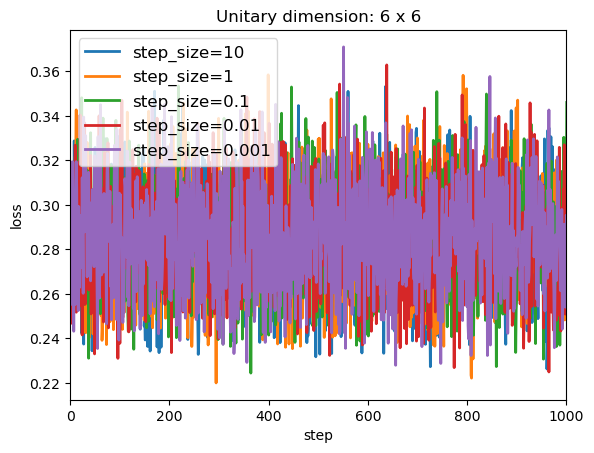

In [ ]:
# Varying the step size.
#THIS NEEDS TO BE FIXED. We need to ensure the recompilation of the train function with the new step size.
step_size_list = [10, 1, 1e-1,  1e-2, 1e-3]

fig, ax = plt.subplots()  # Create the figure and axis before the loop
loss_train = []
loss_test = []
for i in range(len(step_size_list)):
    step_size = step_size_list[i]
    print('Step size:', step_size)

    # Reinitialize the phases for each step size.
    init_phases = initialize_phases(2*num_features, )
    # Initialize the carry for Adam.
    init = [init_phases, train_set, train_labels, 0.0*init_phases, 0.0*init_phases]
    

    # Run the training.
    b = time.time()
    trained_phases, loss_mem = jax.block_until_ready(train)(init)
    #print(loss_mem[0])
    #print(loss_mem[10])
    #print(loss_mem[100])
    #print(loss_mem[1000])
    e = time.time()
    print(f"Time: {e-b:.2f} seconds ({(e-b)/60:.2f} minutes)")


    temp_loss = loss(init_phases, train_set, train_labels)
    #print('Loss on train set:', temp_loss)

    loss_train.append([temp_loss])
    
    temp_loss = loss(trained_phases, test_set, test_labels)
    loss_test.append([temp_loss])
    # Let's test on our test data:
    #print('Loss on test set:', temp_loss)

    # Plot learning curve for this run
    ax.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), linewidth=2, label=f"step_size={step_size}")

ax.set(xlim=(0,1000), xlabel="step", ylabel="loss")
ax.legend(fontsize=12)
unitary_shape = trained_phases.shape
ax.set_title(f"Unitary dimension: {unitary_shape[0]} x {unitary_shape[0]}")

plt.show()

#for i in range(len(loss_train)):
#    print(f"Step size: {step_size_list[i]:.1e} | Train loss: {loss_train[i][0]:.4f} | Test loss: {loss_test[i][0]:.4f}")

In [42]:
unitary_shape = trained_phases.shape  # e.g., (1000, 10, 10)
print(unitary_shape)

(10, 3, 2)
